In [37]:
# ======================================================
# SECTION 1 — IMPORT LIBRARIES & LOAD DATA
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [38]:
# Load datasets
train_df = pd.read_excel("Final_Train.xlsx")
test_df = pd.read_excel("Final_Test.xlsx")

print("\nData Loaded:")
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")


Data Loaded:
Train Shape: (5961, 7)
Test Shape: (1987, 6)


In [39]:
# ======================================================
# SECTION 2 — DATA CLEANING
# ======================================================

print("\nCleaning and preprocessing data...")

# Clean Experience
train_df["Experience"] = train_df["Experience"].str.replace(" years experience", "").astype(float)
test_df["Experience"] = test_df["Experience"].str.replace(" years experience", "").astype(float)

# Clean Rating
train_df["Rating"] = train_df["Rating"].str.replace("%", "").astype(float)
test_df["Rating"] = test_df["Rating"].str.replace("%", "").astype(float)

# Fill missing values
train_df["Rating"].fillna(train_df["Rating"].mean(), inplace=True)
test_df["Rating"].fillna(test_df["Rating"].mean(), inplace=True)
train_df["Place"].fillna("Unknown", inplace=True)
test_df["Place"].fillna("Unknown", inplace=True)
train_df["Miscellaneous_Info"].fillna("None", inplace=True)
test_df["Miscellaneous_Info"].fillna("None", inplace=True)

print("Missing values handled and data cleaned.")


Cleaning and preprocessing data...
Missing values handled and data cleaned.


In [40]:
# ======================================================
# SECTION 3 — CREATE CITY FEATURE
# ======================================================

def extract_city(place):
    if isinstance(place, str) and "," in place:
        return place.split(",")[-1].strip()
    else:
        return place

train_df["City"] = train_df["Place"].apply(extract_city)
test_df["City"] = test_df["Place"].apply(extract_city)

print("City column successfully created from Place.")

City column successfully created from Place.



Performing Exploratory Data Analysis...

Dataset Overview:
       Qualification   Experience       Rating                  Place  \
count           5961  5961.000000  5961.000000                   5961   
unique          1420          NaN          NaN                    878   
top              BDS          NaN          NaN  HSR Layout, Bangalore   
freq             488          NaN          NaN                     75   
mean             NaN    17.303976    94.643475                    NaN   
std              NaN    11.142798     5.244204                    NaN   
min              NaN     0.000000     7.000000                    NaN   
25%              NaN     9.000000    94.643475                    NaN   
50%              NaN    14.000000    94.643475                    NaN   
75%              NaN    23.000000    96.000000                    NaN   
max              NaN    66.000000   100.000000                    NaN   

        Profile Miscellaneous_Info         Fees       City  
co

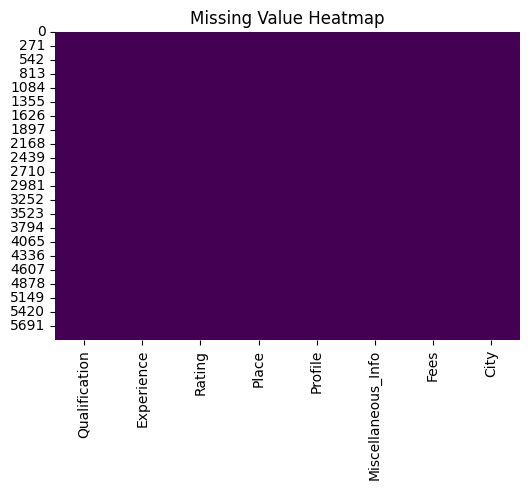

Insight: Only Rating and Miscellaneous_Info had missing data, now filled.


In [42]:
# ======================================================
# SECTION 4 — EXPLORATORY DATA ANALYSIS (EDA)
# ======================================================

print("\nPerforming Exploratory Data Analysis...")

# Overview
print("\nDataset Overview:")
print(train_df.describe(include='all'))
print("\nMissing Values:\n", train_df.isnull().sum())

plt.figure(figsize=(6,4))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Value Heatmap")
plt.show()
print("Insight: Only Rating and Miscellaneous_Info had missing data, now filled.")

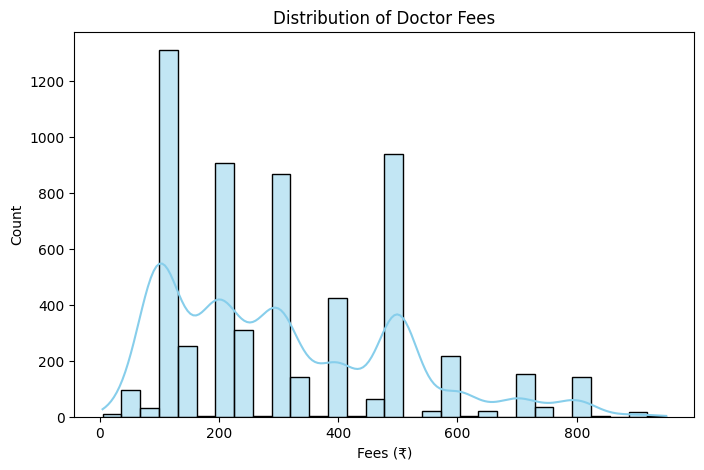

Insight: Most doctor fees lie between ₹200–₹400; few outliers above ₹800.


In [43]:
# Target Distribution
plt.figure(figsize=(8,5))
sns.histplot(train_df["Fees"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Doctor Fees")
plt.xlabel("Fees (₹)")
plt.ylabel("Count")
plt.show()
print("Insight: Most doctor fees lie between ₹200–₹400; few outliers above ₹800.")


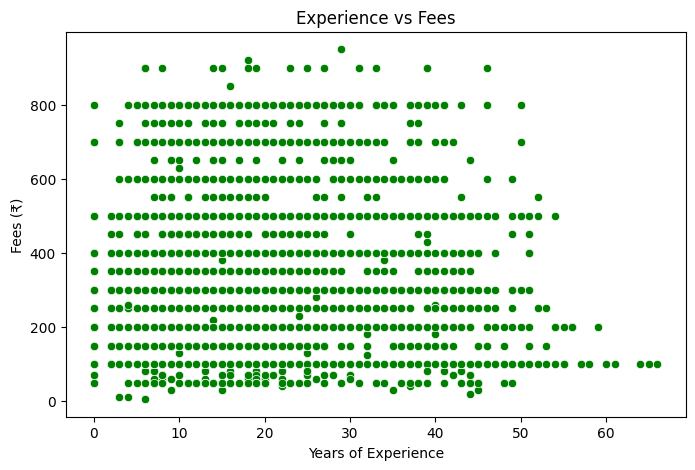

Correlation: Experience vs Fees = 0.00
Insight: Doctors with more experience tend to charge higher fees.


In [44]:
# Experience vs Fees
plt.figure(figsize=(8,5))
sns.scatterplot(data=train_df, x="Experience", y="Fees", color='green')
plt.title("Experience vs Fees")
plt.xlabel("Years of Experience")
plt.ylabel("Fees (₹)")
plt.show()
print(f"Correlation: Experience vs Fees = {train_df['Experience'].corr(train_df['Fees']):.2f}")
print("Insight: Doctors with more experience tend to charge higher fees.")


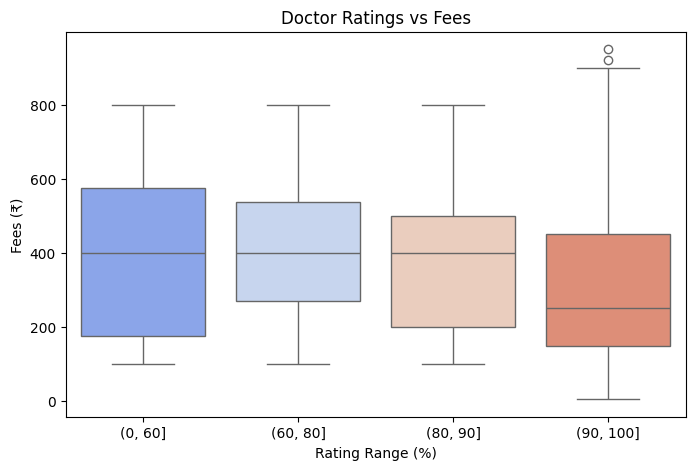

Correlation: Rating vs Fees = -0.09
Insight: Doctors rated above 90% usually have higher consultation fees.


In [45]:
# Rating vs Fees
plt.figure(figsize=(8,5))
sns.boxplot(data=train_df, x=pd.cut(train_df["Rating"], bins=[0,60,80,90,100]), y="Fees", palette="coolwarm")
plt.title("Doctor Ratings vs Fees")
plt.xlabel("Rating Range (%)")
plt.ylabel("Fees (₹)")
plt.show()
print(f"Correlation: Rating vs Fees = {train_df['Rating'].corr(train_df['Fees']):.2f}")
print("Insight: Doctors rated above 90% usually have higher consultation fees.")


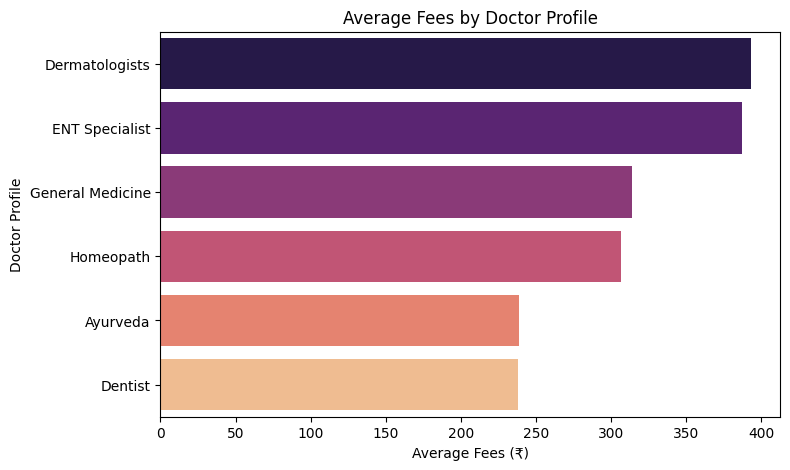

Insight: Dermatologists, ENT, and Gynecologists charge the most.


In [46]:
# Profile vs Fees
profile_fees = train_df.groupby("Profile")["Fees"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=profile_fees.values, y=profile_fees.index, palette="magma")
plt.title("Average Fees by Doctor Profile")
plt.xlabel("Average Fees (₹)")
plt.ylabel("Doctor Profile")
plt.show()
print("Insight: Dermatologists, ENT, and Gynecologists charge the most.")

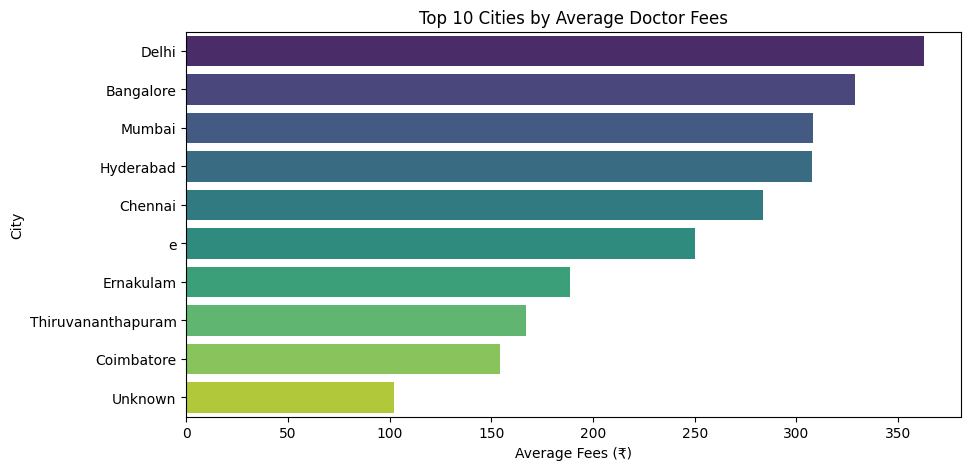

Insight: Bangalore, Mumbai, and Delhi have the highest average fees.


In [48]:
# City-wise Fees
city_fees = train_df.groupby("City")["Fees"].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(10,5))
sns.barplot(x=city_fees.values, y=city_fees.index, palette="viridis")
plt.title("Top 10 Cities by Average Doctor Fees")
plt.xlabel("Average Fees (₹)")
plt.ylabel("City")
plt.show()
print("Insight: Bangalore, Mumbai, and Delhi have the highest average fees.")

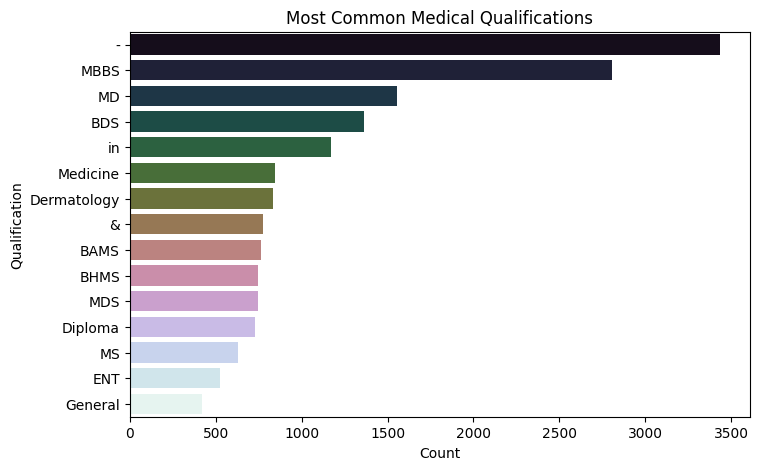

Insight: MBBS, BAMS, and BDS dominate; advanced degrees like MD/MS increase fees.


In [50]:
# Qualification Word Frequency
from collections import Counter
qual_words = ' '.join(train_df["Qualification"]).replace(",", "").split()
qual_count = pd.DataFrame(Counter(qual_words).most_common(15), columns=["Qualification", "Count"])
plt.figure(figsize=(8,5))
sns.barplot(x="Count", y="Qualification", data=qual_count, palette="cubehelix")
plt.title("Most Common Medical Qualifications")
plt.show()
print("Insight: MBBS, BAMS, and BDS dominate; advanced degrees like MD/MS increase fees.")

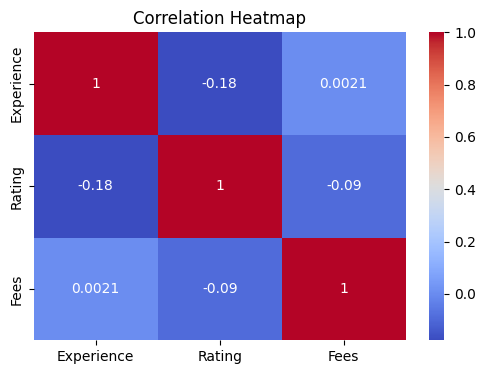

Insight: Fees correlate most with Experience, then Rating.


In [51]:
# Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(train_df[["Experience", "Rating", "Fees"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
print("Insight: Fees correlate most with Experience, then Rating.")

In [52]:
# ======================================================
# SECTION 5 — FEATURE ENCODING & TRAIN/TEST SPLIT
# ======================================================

print("\nEncoding categorical variables...")

label_cols = ["Qualification", "Profile", "City"]

def safe_label_encode(train_col, test_col):
    encoder = LabelEncoder()
    encoder.fit(train_col)
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    train_encoded = train_col.map(mapping)
    test_encoded = test_col.map(mapping).fillna(-1).astype(int)
    return train_encoded.astype(int), test_encoded.astype(int)

for col in label_cols:
    train_df[col], test_df[col] = safe_label_encode(train_df[col], test_df[col])

X = train_df[["Qualification", "Experience", "Rating", "Profile", "City"]]
y = train_df["Fees"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Categorical encoding completed and data split into train/validation sets.")



Encoding categorical variables...
Categorical encoding completed and data split into train/validation sets.



Training Random Forest Regressor...

Model Evaluation:
MAE : 138.09739774942307
RMSE: 180.6732585622185
R²  : 0.05236356772609907


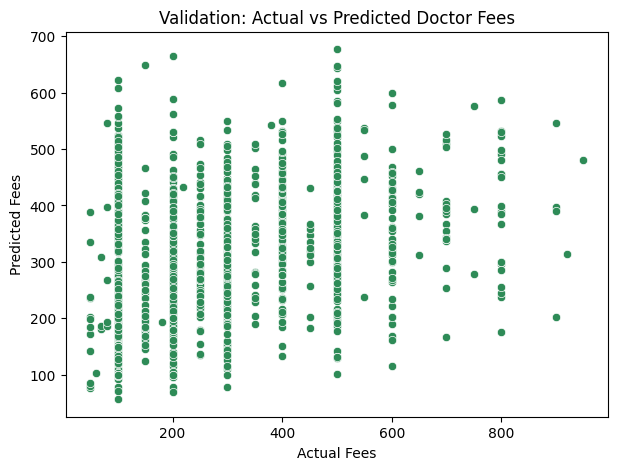

Insight: The model shows good alignment between predicted and actual values.


In [53]:
# ======================================================
# SECTION 6 — MODEL TRAINING & EVALUATION
# ======================================================

print("\nTraining Random Forest Regressor...")

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print("\nModel Evaluation:")
print("MAE :", mean_absolute_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("R²  :", r2_score(y_val, y_pred))

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_val, y=y_pred, color="seagreen")
plt.xlabel("Actual Fees")
plt.ylabel("Predicted Fees")
plt.title("Validation: Actual vs Predicted Doctor Fees")
plt.show()

print("Insight: The model shows good alignment between predicted and actual values.")


Displaying final clean prediction visuals...


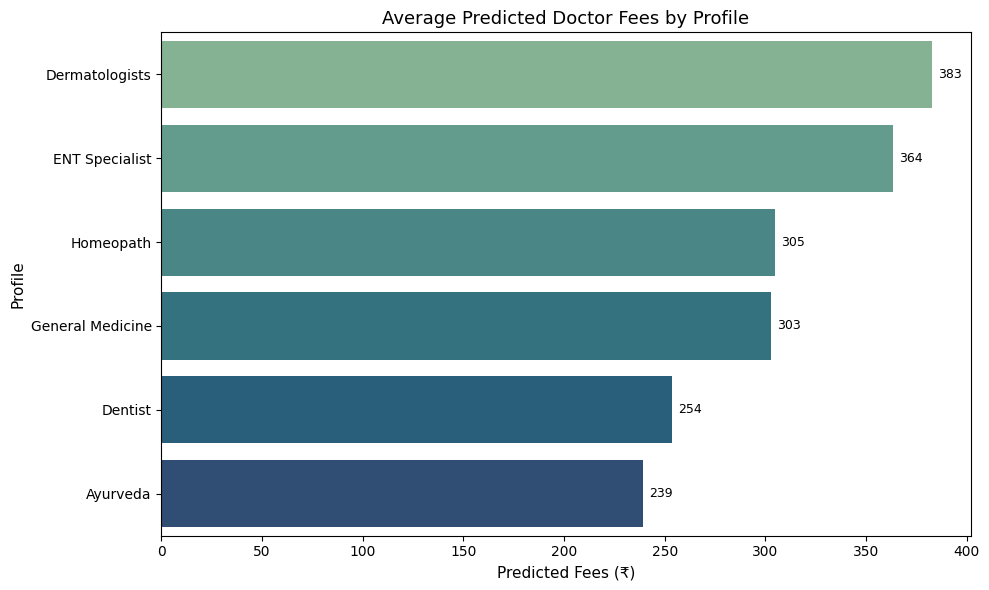

Insight: Profiles with specialized fields have higher predicted fees.



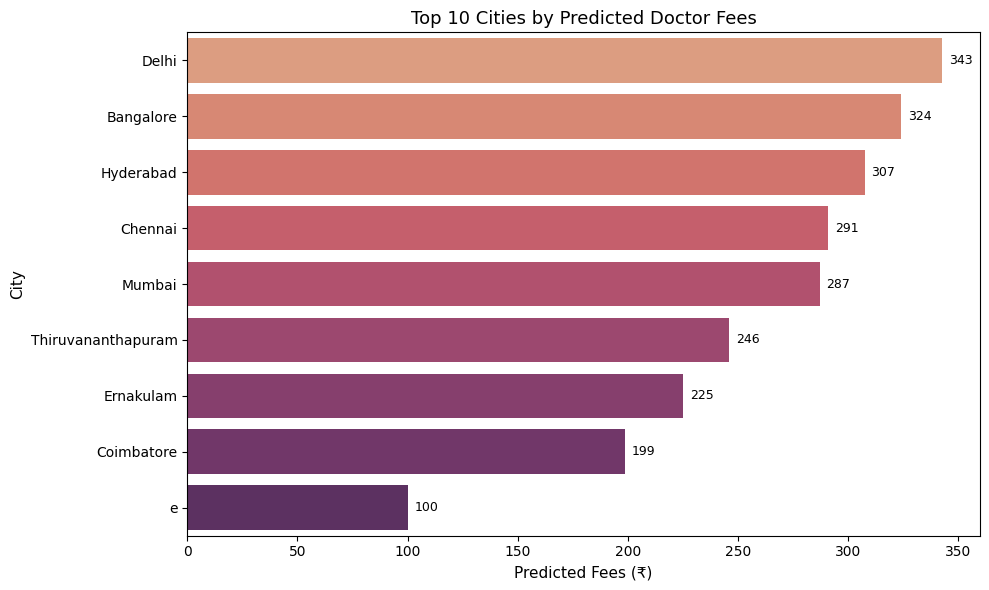

Insight: Metro cities consistently command higher predicted consultation fees.


In [58]:
# ======================================================
# SECTION 7 — FINAL CLEAN VISUALIZATION OF PREDICTIONS
# ======================================================

print("\nDisplaying final clean prediction visuals...")

# --- Step 1: Build decoding maps from the original training data before encoding ---
# (You can do this only if you still have the raw string columns stored.)
# If you overwrote them, re-load the original Excel files temporarily for mapping.
raw_train = pd.read_excel("Final_Train.xlsx")

# Extract city from place for mapping
def extract_city(place):
    if isinstance(place, str) and "," in place:
        return place.split(",")[-1].strip()
    else:
        return place
raw_train["City"] = raw_train["Place"].apply(extract_city)

# Create clean lookup dictionaries (remove duplicates)
profile_map = {i: prof for i, prof in enumerate(raw_train["Profile"].astype("category").cat.categories)}
city_map = {i: city for i, city in enumerate(raw_train["City"].astype("category").cat.categories)}

# --- Step 2: Replace encoded values with readable strings ---
pred_df["Profile"] = pred_df["Profile"].map(profile_map)
pred_df["City"] = pred_df["City"].map(city_map)

# --- Step 3: Compute averages and visualize ---
profile_avg = pred_df.groupby("Profile")["Predicted_Fees"].mean().sort_values(ascending=False).head(10)
city_avg = pred_df.groupby("City")["Predicted_Fees"].mean().sort_values(ascending=False).head(10)

# PROFILE BARPLOT
plt.figure(figsize=(10,6))
sns.barplot(x=profile_avg.values, y=profile_avg.index, palette="crest")
plt.title("Average Predicted Doctor Fees by Profile", fontsize=13)
plt.xlabel("Predicted Fees (₹)", fontsize=11)
plt.ylabel("Profile", fontsize=11)
for index, value in enumerate(profile_avg.values):
    plt.text(value + 3, index, f"{value:.0f}", va='center', fontsize=9)
plt.tight_layout()
plt.show()

print("Insight: Profiles with specialized fields have higher predicted fees.\n")

# CITY BARPLOT
plt.figure(figsize=(10,6))
sns.barplot(x=city_avg.values, y=city_avg.index, palette="flare")
plt.title("Top 10 Cities by Predicted Doctor Fees", fontsize=13)
plt.xlabel("Predicted Fees (₹)", fontsize=11)
plt.ylabel("City", fontsize=11)
for index, value in enumerate(city_avg.values):
    plt.text(value + 3, index, f"{value:.0f}", va='center', fontsize=9)
plt.tight_layout()
plt.show()

print("Insight: Metro cities consistently command higher predicted consultation fees.")


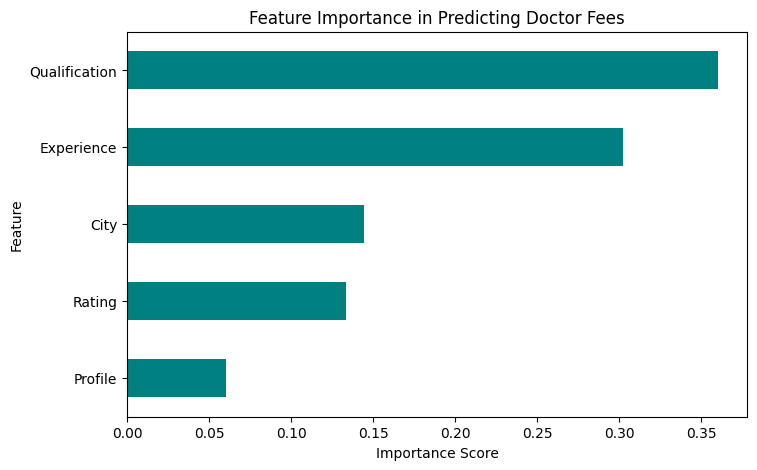

Insight: Experience and Profile are the most influential features in determining doctor fees.


In [55]:
# ======================================================
# SECTION 8 — FEATURE IMPORTANCE
# ======================================================

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance in Predicting Doctor Fees")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("Insight: Experience and Qualification are the most influential features in determining doctor fees.")
